In [1]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ta2sjeqa
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ta2sjeqa
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184468 sha256=400c1ddbac741d20becde585261460308b126866d7e40eafb1c9d161c58040f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-e7hvqrp6/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 13.5 MB/s 


In [2]:
import glob
import matplotlib.pyplot as plt
import imageio
import numpy as np
import os
import PIL
import time
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

from IPython import display


In [3]:
LEARNING_RATE = 3e-4
WEIGHT_DECAY =  1e-6
MOMENTUM = 0.9
LAM_REC = 0.99
LAM_ADV = 1-LAM_REC

DROP_SIZE =  0.5

BATCH_SIZE = 128
EPOCHS = 10

In [4]:
(train_images, _), (test_images,_) = tf.keras.datasets.cifar10.load_data()
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
train_images = (train_images - 127.5 ) / 127.5  # Normalize the images to [-1, 1]
test_images = (test_images - 127.5 ) / 127.5  # Normalize the images to [-1, 1]

170498071/170498071 [==============================] - 6s 0us/step


In [5]:
# cutout 
x_train = tfa.image.cutout(train_images, mask_size=(16,16), offset=(16,16))
x_test = tfa.image.cutout(test_images, mask_size=(16,16), offset=(16,16))

In [6]:
even = len(train_images) - (len(train_images) % BATCH_SIZE)
last_batch = train_images[even:]
x_train = tf.split(x_train[:even],num_or_size_splits=int(len(train_images)/BATCH_SIZE), axis=0, name='split')
y_train = tf.split(train_images[:even],num_or_size_splits=int(len(train_images)/BATCH_SIZE), axis=0, name='split')
len(y_train)

390

In [7]:
even = len(test_images) - (len(test_images) % BATCH_SIZE)
last_batch = test_images[even:]
x_test = tf.split(x_test[:even],num_or_size_splits=int(len(test_images)/BATCH_SIZE), axis=0,name='split')
y_test = tf.split(test_images[:even],num_or_size_splits=int(len(test_images)/BATCH_SIZE), axis=0,name='split')
len(y_test)

78

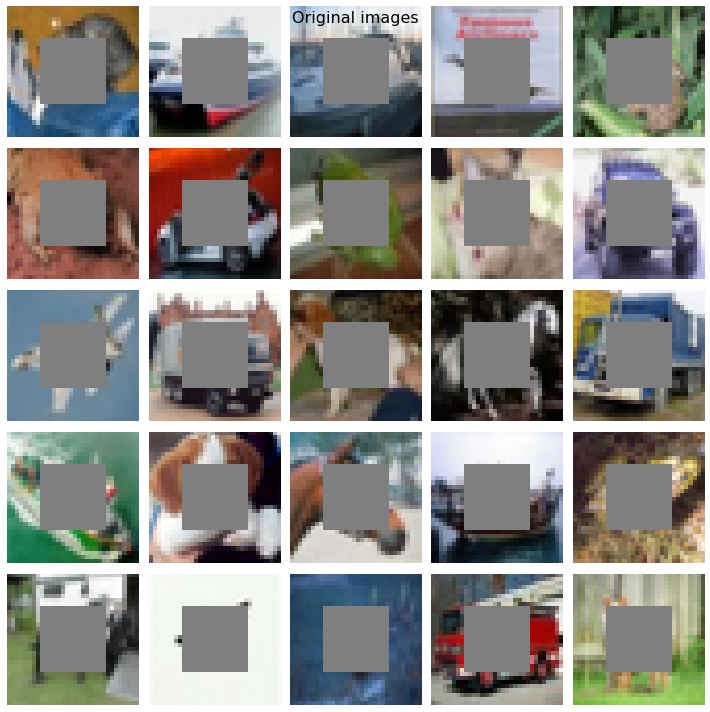

In [8]:
y = x_test[0][:25]

fig = plt.figure(figsize=(10, 10))
plt.suptitle("Original images", fontsize=16)
for i in range(y.shape[0]):
    plt.subplot(5,5, i+1)
    plt.imshow((y[i] + 1. ) /2 )
    plt.axis('off')

plt.tight_layout()
plt.savefig('image_at_epoch_0000.png')
plt.show()

In [9]:
def Generator(input_shape=(32,32,3)):
    inputs = layers.Input(input_shape)
    # PART I
    # Encoder
    x = layers.Conv2D(64, (4,4), strides=2, padding="same", name="conv1")(inputs) 
    x = layers.BatchNormalization(name="batch_norm_1")(x)
    x = layers.LeakyReLU(name="leaky_relu_1")(x)

    x = layers.Conv2D(64, (4,4), strides=2, padding="same", name="conv2")(inputs) 
    x = layers.BatchNormalization(name="batch_norm_2")(x)
    x = layers.LeakyReLU(name="leaky_relu_2")(x)

    x = layers.Conv2D(128, (4,4), strides=2, padding="same", name="conv3")(x)
    x = layers.BatchNormalization(name="batch_norm_3")(x)
    x = layers.LeakyReLU(name="leaky_relu_3")(x)

    x = layers.Conv2D(256, (4,4), strides=2, padding="same", name="conv4")(x)
    x = layers.BatchNormalization(name="batch_norm_4")(x)
    x = layers.LeakyReLU(name="leaky_relu_4")(x)

    x = layers.Conv2D(512, (4,4), strides=1, padding="same", name="conv5")(x)
    x = layers.BatchNormalization(name="batch_norm_5")(x)
    x = layers.LeakyReLU(name="leaky_relu_5")(x)


    x = layers.Conv2D(1000, (4,4), strides=1, padding="valid")(x)

    # PART II
    # Decoder
    x = layers.Conv2DTranspose(512, (4,4), strides=2, padding='valid', name="deconv1")(x)
    x = layers.BatchNormalization(name="batch_norm_6")(x)
    x = layers.ReLU(name="relu_1")(x)

    x = layers.Conv2DTranspose(256, (4,4), strides=1, padding='same',name="deconv2")(x)
    x = layers.BatchNormalization(name="batch_norm_7")(x)
    x = layers.ReLU(name="relu_2")(x)

    x = layers.Conv2DTranspose(128, (4,4), strides=1, padding='same',name="deconv3")(x)
    x = layers.BatchNormalization(name="batch_norm_8")(x)
    x = layers.ReLU(name="relu_3")(x)

    x = layers.Conv2DTranspose(64, (4,4), strides=2, padding='same',name="deconv4")(x)
    x = layers.BatchNormalization(name="batch_norm_9")(x)
    x = layers.ReLU(name="relu_4")(x)

    outputs = layers.Conv2DTranspose(3, 3, strides=(2, 2), padding='same',name="deconv5", activation='tanh')(x)

    model = tf.keras.Model(inputs, outputs, name="Generator")

    return model

generator = Generator()
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 64)        3136      
                                                                 
 batch_norm_2 (BatchNormaliz  (None, 16, 16, 64)       256       
 ation)                                                          
                                                                 
 leaky_relu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 8, 8, 128)         131200    
                                                                 
 batch_norm_3 (BatchNormaliz  (None, 8, 8, 128)        512       
 ation)                                                  

In [10]:
def Discriminator(input_shape=(16,16,3)):
    inputs = layers.Input((input_shape))
    x = layers.Conv2D(64, (4,4), strides=2, padding="same", name="conv1")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, (4,4), strides=2, padding="same", name="conv2")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, (4,4), strides=2, padding="same", name="conv3")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, (4,4), strides=1, padding="same", name="conv4")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs, name="Discriminator")
    return model

discriminator = Discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 8, 8, 64)          3136      
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 64)         256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 64)          0         
                                                                 
 conv2 (Conv2D)              (None, 4, 4, 128)         131200    
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 128)        512       
 hNormalization)                                     

In [11]:
class ContextEncoder():
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, name="context-encoder"):
      self.generator = Generator()
      self.discriminator = Discriminator()

      self.metrics = []

      self.generator_loss = None
      self.discriminator_loss = None

      self.generator_optimizer = None
      self.discriminator_optimizer = None

      self.history = {'gen_loss':[],
            'disc_loss':[],
             'val_gen_loss':[],
            'val_disc_loss':[],
             'metric':[],
             'val_metric':[],
            'epochs':[],
            }

    def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss, metrics):
      self.generator_optimizer = generator_optimizer
      self.generator_loss = generator_loss
      self.discriminator_optimizer=discriminator_optimizer
      self.discriminator_loss = discriminator_loss
      self.metrics = metrics

    def predict(self, X):
      return self.generator(X)

    def fit(self, X, y, val_data=None, epochs=1, shuffle=True, warm_start=0, images_to_show=None, show=False ):

      if warm_start>0:
        print(f"Warm up:")
        for pre_epoch in range(1,warm_start+1):
          print(f'Epoch {pre_epoch}/{warm_start}')
          if shuffle:
            indices = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
            shuffled_indices = tf.random.shuffle(indices)

            X = tf.gather(X, shuffled_indices)
            y = tf.gather(y, shuffled_indices)
          
          # progres bar
          step = 0
          pbar = tf.keras.utils.Progbar(target=len(X), stateful_metrics=[])
          stats = {}

          ########################################################################
          # WARM UP
          epoch_gen_loss,epoch_disc_loss, epoch_metric =[],[], []
          for x_batch, y_batch in zip(X,y):
            gen_loss, disc_loss, metric = self.warm_up_step(x_batch, y_batch)

            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)
            epoch_metric.append(metric)

            stats.update({'gen_loss':np.mean(epoch_gen_loss), 
                          'disc_loss':np.mean(epoch_disc_loss),
                          'metric':np.mean(epoch_metric)})
            pbar.update(step, values=stats.items(), finalize=False)
            step += 1

          # VALIDATION
          epoch_val_gen_loss, epoch_val_disc_loss, epoch_val_metric =[],[], []
          for x_batch, y_batch in zip(val_data[0], val_data[1]):
            val_gen_loss, val_disc_loss, val_metric = self.val_step(x_batch, y_batch)

            epoch_val_gen_loss.append(val_gen_loss)
            epoch_val_disc_loss.append(val_disc_loss)
            epoch_val_metric.append(val_metric)

            stats.update({'val_gen_loss':np.mean(epoch_val_gen_loss), 
                          'val_disc_loss':np.mean(epoch_val_disc_loss),
                          'val_metric':np.mean(epoch_val_metric)})

          pbar.update(step, values=stats.items(), finalize=True)
          # update history
          self.history['epochs'].append(pre_epoch)
          self.history['gen_loss'].append(np.mean(epoch_gen_loss))
          self.history['disc_loss'].append(np.mean(epoch_disc_loss))

          self.history['val_gen_loss'].append(np.mean(epoch_val_gen_loss))
          self.history['val_disc_loss'].append(np.mean(epoch_val_disc_loss))

          self.history['metric'].append(np.mean(epoch_metric))
          self.history['val_metric'].append(np.mean(epoch_val_metric))

          if images_to_show is not None:
            self.generate_and_save_images(pre_epoch, images_to_show, show)


      print(f"Training")
      for epoch in range(warm_start+1,epochs + warm_start+1):
        print(f'Epoch {epoch}/{epochs+warm_start}')
        # shuffle training data
        if shuffle:
          indices = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
          shuffled_indices = tf.random.shuffle(indices)

          X = tf.gather(X, shuffled_indices)
          y = tf.gather(y, shuffled_indices)

        # progres bar
        step = 0
        pbar = tf.keras.utils.Progbar(target=len(X), stateful_metrics=[])
        stats = {}

        ########################################################################
        # TRAINING
        epoch_gen_loss,epoch_disc_loss, epoch_metric =[],[], []
        for x_batch, y_batch in zip(X,y):
          gen_loss, disc_loss, metric = self.train_step(x_batch, y_batch)

          epoch_gen_loss.append(gen_loss)
          epoch_disc_loss.append(disc_loss)
          epoch_metric.append(metric)

          stats.update({'gen_loss':np.mean(epoch_gen_loss), 
                        'disc_loss':np.mean(epoch_disc_loss),
                        'metric':np.mean(epoch_metric)})
          pbar.update(step, values=stats.items(), finalize=False)
          step += 1

        ########################################################################
        # VALIDATION
        epoch_val_gen_loss, epoch_val_disc_loss, epoch_val_metric =[],[], []
        for x_batch, y_batch in zip(val_data[0], val_data[1]):
          val_gen_loss, val_disc_loss, val_metric = self.val_step(x_batch, y_batch)

          epoch_val_gen_loss.append(val_gen_loss)
          epoch_val_disc_loss.append(val_disc_loss)
          epoch_val_metric.append(val_metric)

          stats.update({'val_gen_loss':np.mean(epoch_val_gen_loss), 
                        'val_disc_loss':np.mean(epoch_val_disc_loss),
                        'val_metric':np.mean(epoch_val_metric)})

        pbar.update(step, values=stats.items(), finalize=True)

        ########################################################################
        
        # update history
        self.history['epochs'].append(epoch)
        self.history['gen_loss'].append(np.mean(epoch_gen_loss))
        self.history['disc_loss'].append(np.mean(epoch_disc_loss))

        self.history['val_gen_loss'].append(np.mean(epoch_val_gen_loss))
        self.history['val_disc_loss'].append(np.mean(epoch_val_disc_loss))

        self.history['metric'].append(np.mean(epoch_metric))
        self.history['val_metric'].append(np.mean(epoch_val_metric))

        if images_to_show is not None:
          self.generate_and_save_images(epoch, images_to_show, show)

      return self.history



    def generate_and_save_images(self, epoch, images_to_show, show=False):
      # Notice `training` is set to False.
      # This is so all layers run in inference mode (batchnorm).

      generated = self.generator(images_to_show, training=False)

      paddings = tf.constant([[0, 0,], [8, 8], [8, 8], [0,0]])
      reconstructed_images = images_to_show + tf.pad(generated,paddings)
      if show:
        plt.ion()
      else:
        plt.ioff()

      fig = plt.figure(figsize=(10, 10))
      plt.suptitle(f"epoch:{epoch}")
      for i in range(reconstructed_images.shape[0]):
          plt.subplot(5,5, i+1)
          plt.imshow((reconstructed_images[i] + 1. ) /2 )
          plt.axis('off')
      plt.tight_layout()
      plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

      if show:
        plt.show()
      else:
        plt.close(fig)

    def val_step(self, x_batch, y_batch):

      generated = self.generator(x_batch, training=False)
      ground_truth = tf.image.central_crop(y_batch, 0.5)

      real_output = self.discriminator(ground_truth, training=False)
      fake_output = self.discriminator(generated, training=False)

      disc_loss = self.discriminator_loss(real_output, fake_output)
      gen_loss = self.generator_loss(ground_truth, generated, fake_output)

      metric = self.metrics(ground_truth, generated)

      return gen_loss, disc_loss, metric

    def train_step(self, x_batch, y_batch):

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = self.generator(x_batch, training=True)
        ground_truth = tf.image.central_crop(y_batch, 0.5)

        real_output = self.discriminator(ground_truth, training=True)
        fake_output = self.discriminator(generated, training=True)

        disc_loss = self.discriminator_loss(real_output, fake_output)
        gen_loss = self.generator_loss(ground_truth, generated, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

      self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
      self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

      metric = self.metrics(ground_truth, generated)

      return gen_loss, disc_loss, metric

    def warm_up_step(self, x_batch, y_batch):
  
      with tf.GradientTape() as gen_tape:
        generated = self.generator(x_batch, training=True)
        ground_truth = tf.image.central_crop(y_batch, 0.5)

        real_output = self.discriminator(ground_truth, training=True)
        fake_output = self.discriminator(generated, training=True)

        disc_loss = self.discriminator_loss(real_output, fake_output)
        gen_loss = self.generator_loss(ground_truth, generated, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)

      self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

      metric = self.metrics(ground_truth, generated)

      return gen_loss, disc_loss, metric

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [13]:
def discriminator_loss(real_preds, fake_preds):
  real_loss = cross_entropy(tf.ones_like(real_preds), real_preds)
  fake_loss = cross_entropy(tf.zeros_like(fake_preds), fake_preds)
  total_loss = real_loss + fake_loss
  return total_loss

discriminator_loss( discriminator(tf.image.central_crop(y_test[0], 0.5), training=False), discriminator(generator(x_test[0]), training=False))

<tf.Tensor: shape=(), dtype=float32, numpy=1.3872206>

In [14]:
def adv_loss(fake_preds):
  return cross_entropy(tf.ones_like(fake_preds), fake_preds)

def rec_loss(y_true, y_pred):
  batch_size = len(y_true)
  return tf.sqrt(tf.nn.l2_loss(y_true - y_pred)) / batch_size

In [24]:
LAM_REC = 0.99
LAM_ADV = 0.01
def generator_loss(ori, reconstructed, fake_preds):
    return LAM_REC * rec_loss(ori, reconstructed) + LAM_ADV * adv_loss(fake_preds)

generator_loss(tf.image.central_crop(y_test[0], 0.5), generator(x_test[0]), discriminator(generator(x_test[0]), training=False))

<tf.Tensor: shape=(), dtype=float32, numpy=0.8362178>

In [25]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (tf.keras.backend.sum(y_true_f + y_pred_f))

def ssim(y_true, y_pred):
  return tf.math.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=2))

def psnr(y_true, y_pred):
  return tf.reduce_mean(tf.image.psnr(y_true, y_pred, 2))

In [26]:
psnr(tf.image.central_crop(y_test[0], 0.5),generator(x_test[1]))

<tf.Tensor: shape=(), dtype=float32, numpy=12.906902>

In [27]:
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE*10)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)


In [28]:
coen = ContextEncoder()
coen.compile(generator_loss = generator_loss, discriminator_loss=discriminator_loss,
             generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer,
             metrics=psnr)

In [29]:
images_to_show = x_test[0][:25]

In [31]:
history = coen.fit(x_train, y_train, 
                     val_data=(x_test, y_test), 
                     epochs=200, 
                     shuffle=True, 
                     warm_start=15, 
                     images_to_show=images_to_show, 
                     show=False)

Warm up:
Epoch 1/15
390/390 [==============================] - 32s 82ms/step - gen_loss: 0.7330 - disc_loss: 3.2125 - metric: 14.0853 - val_gen_loss: 0.6575 - val_disc_loss: 2.5215 - val_metric: 14.9970
Epoch 2/15
390/390 [==============================] - 33s 85ms/step - gen_loss: 0.6024 - disc_loss: 3.1332 - metric: 15.7838 - val_gen_loss: 0.6328 - val_disc_loss: 2.5596 - val_metric: 15.4368
Epoch 3/15
390/390 [==============================] - 33s 85ms/step - gen_loss: 0.5832 - disc_loss: 3.0981 - metric: 16.0880 - val_gen_loss: 0.5977 - val_disc_loss: 2.5764 - val_metric: 15.9127
Epoch 4/15
390/390 [==============================] - 32s 82ms/step - gen_loss: 0.5698 - disc_loss: 3.0534 - metric: 16.2796 - val_gen_loss: 0.5756 - val_disc_loss: 2.4244 - val_metric: 16.2719
Epoch 5/15
390/390 [==============================] - 31s 80ms/step - gen_loss: 0.5600 - disc_loss: 3.0197 - metric: 16.4344 - val_gen_loss: 0.5755 - val_disc_loss: 2.4689 - val_metric: 16.2987
Epoch 6/15
390/390 [=

In [32]:
2## Plot train and validation curves

gen_loss = history['gen_loss']
val_gen_loss = history['val_gen_loss']

disc_loss = history['disc_loss']
val_disc_loss = history['val_disc_loss']

met = history['metric']
val_metric = history['val_metric']

epochs = history['epochs']

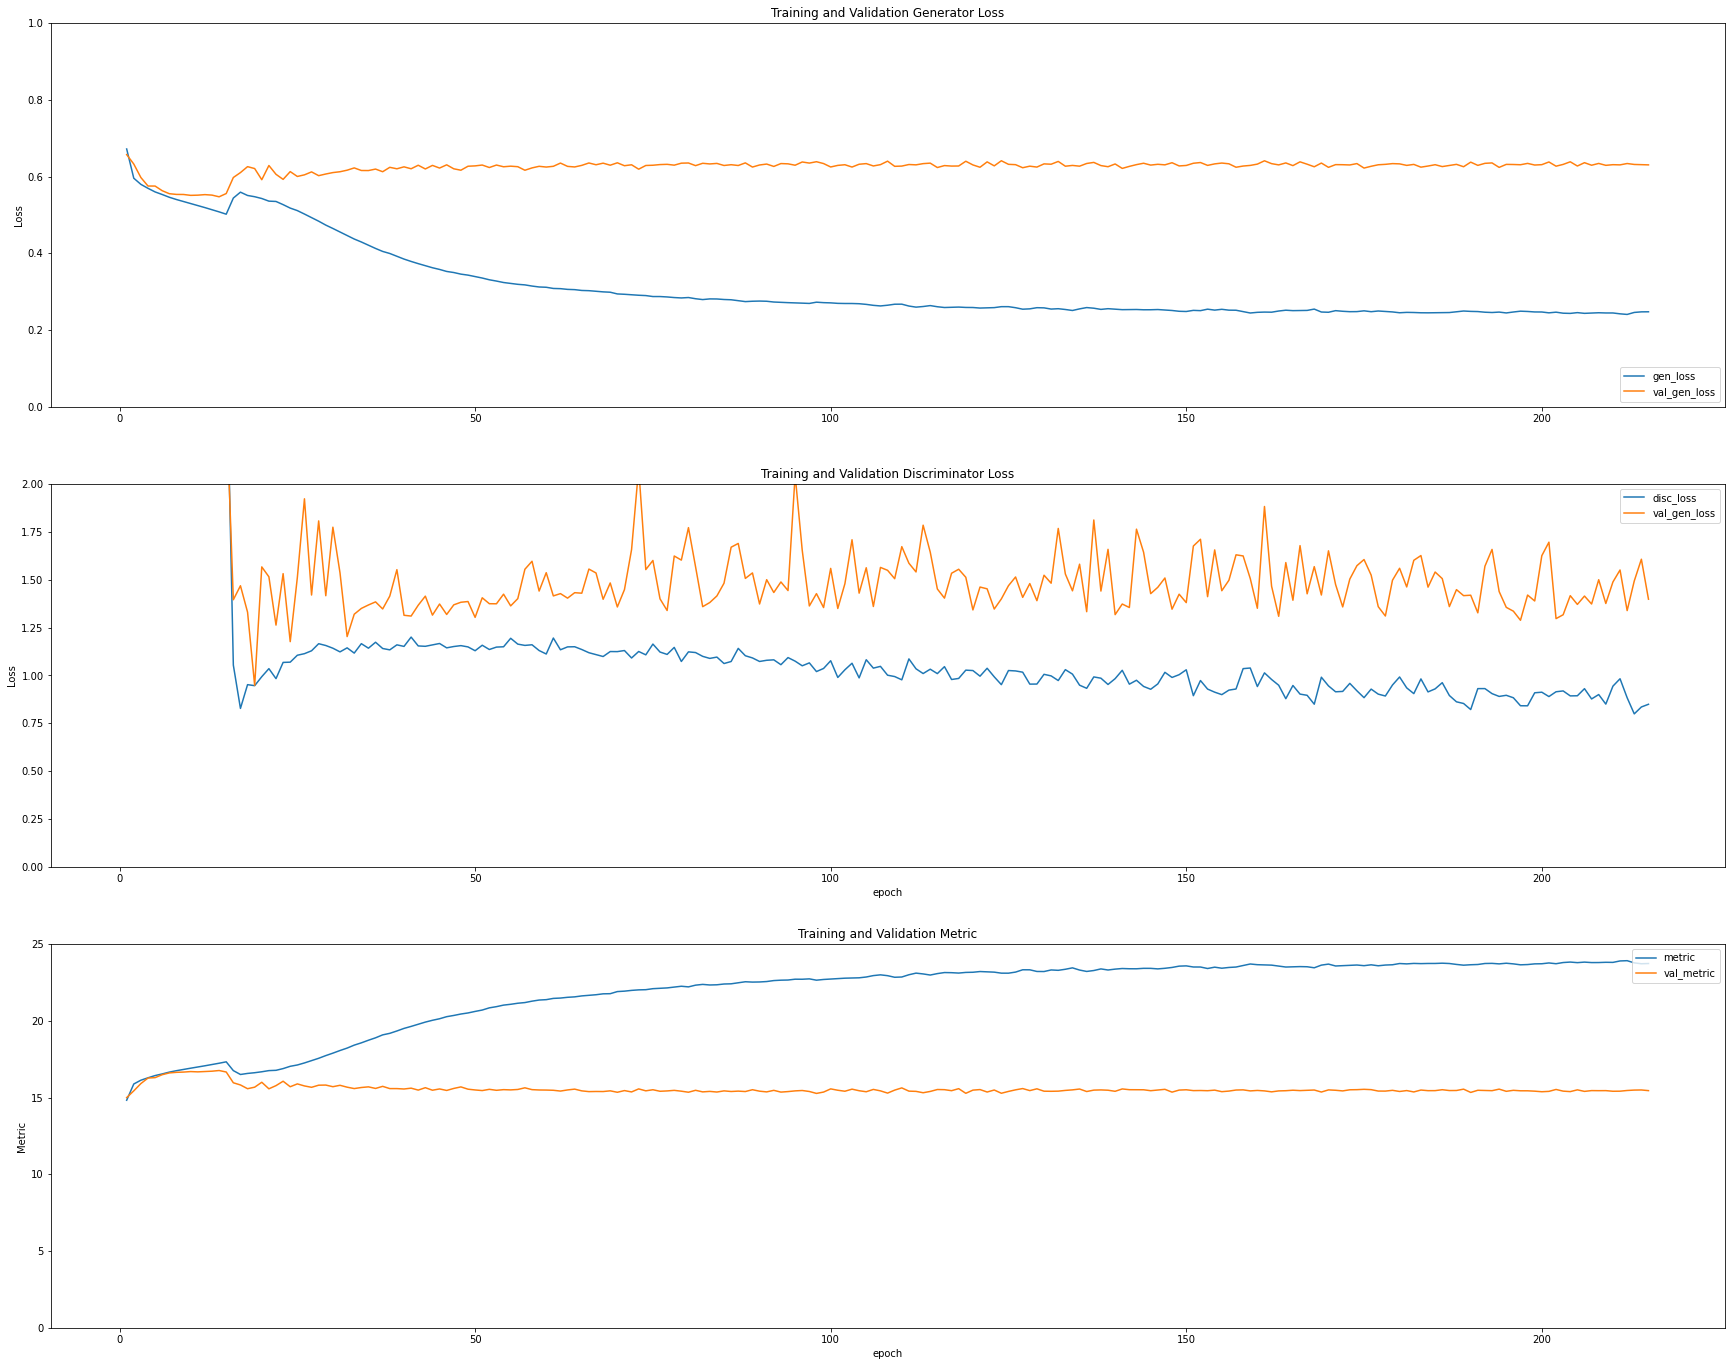

In [34]:
plt.figure(figsize=(30, 24))
plt.subplot(3, 1, 1)
plt.plot(epochs,gen_loss, label='gen_loss')
plt.plot(epochs,val_gen_loss, label='val_gen_loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.title('Training and Validation Generator Loss')

plt.subplot(3, 1, 2)
plt.plot(epochs,disc_loss, label='disc_loss')
plt.plot(epochs,val_disc_loss, label='val_gen_loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.title('Training and Validation Discriminator Loss')
plt.xlabel('epoch')



plt.subplot(3, 1, 3)
plt.plot(epochs,met, label='metric')
plt.plot(epochs,val_metric, label='val_metric')
plt.legend(loc='upper right')
plt.ylabel('Metric')
plt.ylim([0,25])
plt.title('Training and Validation Metric')
plt.xlabel('epoch')

# plt.savefig(OUTPUT_FILEPATH / f'training_history.png',
#              facecolor='white',
#             bbox_inches='tight')
plt.show()

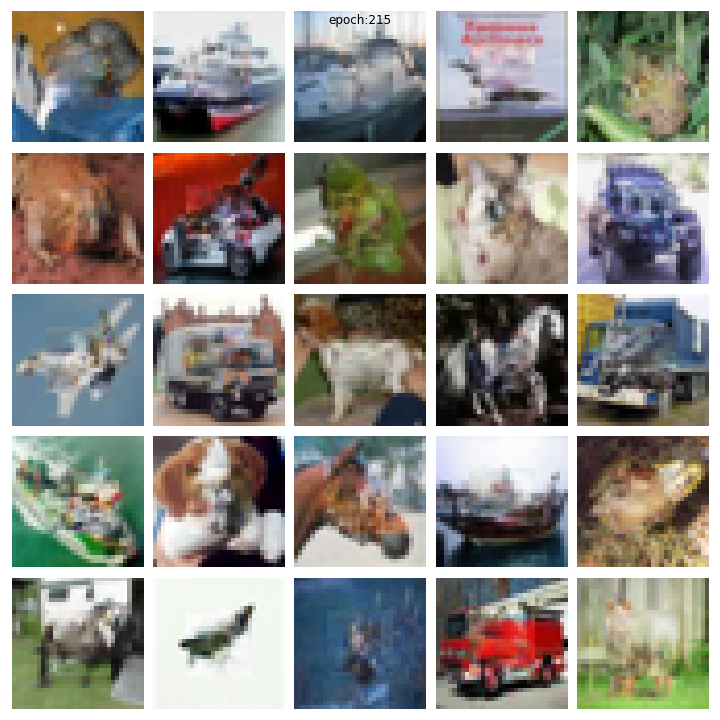

In [35]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(215)

In [37]:
anim_file = 'dcgan.gif'

filenames = glob.glob('image*.png')
filenames = sorted(filenames)
frames = []
for i,filename in enumerate(filenames):
  if i % 10 == 0:
    image = imageio.imread(filename)
    frames.append(image)
imageio.mimsave(anim_file, frames, format='GIF', fps=4)



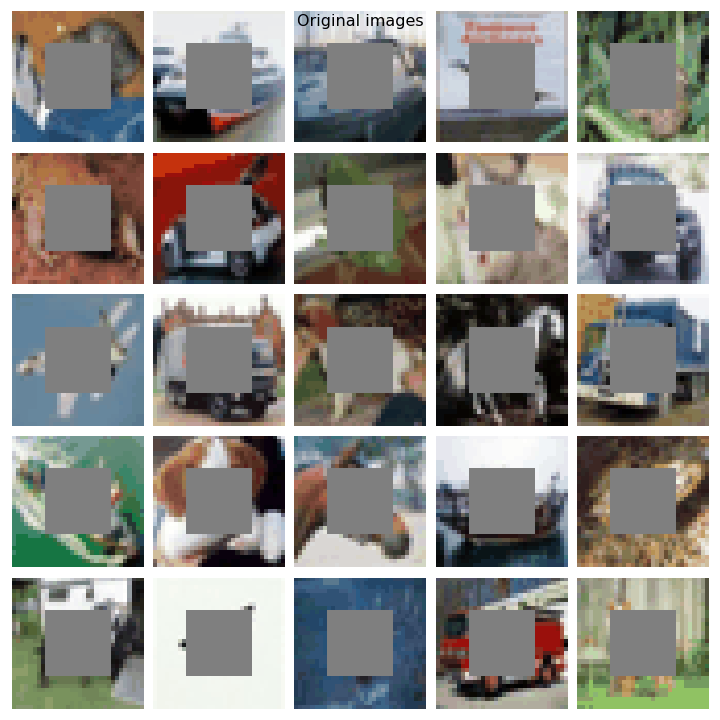

In [38]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)
